### CNN-Variational Autoencoder (CNN-VAE)

**Author**: @leoapuly <br>
**Description**: An implementation of CNN variational auto encoder. A combination of MNIST and USPS charactor recognition datasets is used for training and testing the model.Here the last layer of Encoder is just flattened out to get the embedded representation of the input image <br>
**Status**: Incomplete


In [1]:
from numpy.random import seed
seed(9)
from tensorflow import set_random_seed
set_random_seed(2)
import os
os.environ['PYTHONHASHSEED'] = '0'

CUDA_VISIBLE_DEVICES=""

In [2]:
import os
os.environ["KERAS_BACKEND"] = "theano"
import keras; import keras.backend
if keras.backend.backend() != 'theano':
    raise BaseException("This script uses other backend")
else:
    keras.backend.set_image_dim_ordering('th')
    print("Backend ok")

Using Theano backend.


Backend ok


In [3]:
from keras.models import Model
from keras.losses import *
from keras.objectives import binary_crossentropy
from keras.callbacks import LearningRateScheduler
from keras.models import Sequential,model_from_json
from keras.layers import Dense, Dropout, Flatten,Conv2D, MaxPooling2D, Input, Lambda, Reshape
from keras.utils import np_utils
import matplotlib.pyplot as plt
from keras.layers.advanced_activations import LeakyReLU
from keras import regularizers
from keras import backend as K
K.set_image_dim_ordering('th')
import scipy.misc as misc
import numpy as np
np.set_printoptions(suppress=True)
import keras.backend as K

from dataset import *
from modeling import *

In [4]:
# value declarations
b_size=512
nb_classes=10
epoch=80
img_rows=16
img_cols=16
channel=1
n_z=2

#### Using VAE as a generative model Loading Dataset

Display numpy-images : MNIST 16x16 after normalisation to 0-1
(16, 16)
[[ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.00392157  0.12156863  0.59607846  0.44313726  0.07843138
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.03137255  0.1882353   0.61960787  0.94509804  0.90196079  0.47843137
   0.01568628  0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.00392157
   0.15294118  0.47450981  0.81568629  0.95294118  0.74901962  0.8509804
   0.61960787  0.02352941  0.     

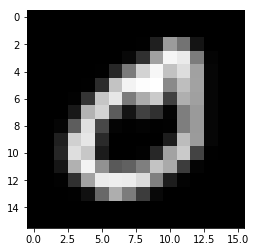

Display numpy-images : USPS 16x16 after normalisation to 0-1
(16, 16)
[[ 0.0000365   0.003178    0.0498455   0.1836895   0.27842751  0.272782
   0.262564    0.284412    0.25273049  0.208176    0.21567351  0.299867
   0.4222725   0.45699951  0.31546149  0.0886945 ]
 [ 0.000079    0.0068555   0.1089155   0.42177501  0.697604    0.74693501
   0.73790002  0.76167899  0.72753447  0.67713702  0.681669    0.74962598
   0.82360899  0.80387199  0.55534202  0.1601465 ]
 [ 0.000054    0.0047745   0.0812955   0.3908405   0.8158865   0.95978302
   0.96468198  0.96276599  0.92502999  0.87904352  0.86345249  0.85652751
   0.83722299  0.783871    0.55056202  0.164014  ]
 [ 0.0000365   0.003278    0.0598465   0.34029251  0.80466747  0.98330301
   0.98204052  0.922566    0.808608    0.67959899  0.60448402  0.53092653
   0.44464701  0.37166101  0.221719    0.059555  ]
 [ 0.0000655   0.005763    0.095676    0.4284105   0.84339702  0.98624599
   0.96179301  0.84984249  0.68738598  0.47737601  0.29939151  0

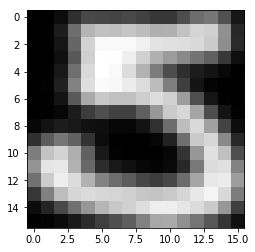

(7000, 16, 16)
(930, 16, 16)
(7000,)
(930,)


/opt/conda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [5]:
mnist_x_new_train, mnist_x_new_test, mnist_y_new_train, mnist_y_new_test,usps_x_new_train, usps_x_new_test, usps_y_new_train, usps_y_new_test=datasets(.1,.1)

mnist_train_y = np_utils.to_categorical(mnist_y_new_train, nb_classes)
usps_train_y = np_utils.to_categorical(usps_y_new_train, nb_classes)
mnist_test_y= np_utils.to_categorical(mnist_y_new_test, nb_classes)
usps_test_y = np_utils.to_categorical((usps_y_new_test), nb_classes)

mnist_x_new_train = mnist_x_new_train.reshape(mnist_x_new_train.shape[0],channel,img_rows, img_cols)
mnist_x_new_test = mnist_x_new_test.reshape(mnist_x_new_test.shape[0],channel,img_rows, img_cols)
usps_x_new_test = usps_x_new_test.reshape(usps_x_new_test.shape[0],channel,img_rows, img_cols)
usps_x_new_train = usps_x_new_train.reshape(usps_x_new_train.shape[0],channel,img_rows, img_cols)

#### Defining model

In [6]:
# Q(z|X) -- encoder part of the variational autoencoder
inputs = Input(shape=(1,16,16,))
layer1=Convolution2D(8,3,3,activation='relu', border_mode="same")(inputs)
layer2=MaxPooling2D((2,2), strides=(2,2))(layer1)
layer3=Convolution2D(16,3,3, activation='relu', border_mode="same")(layer2)
layer4=MaxPooling2D((2,2), strides=(2,2))(layer3)
layer5=Convolution2D(16,4,4,activation='relu', border_mode="valid")(layer4)
layer6=Flatten()(layer5)               
mu = Dense(n_z, activation='linear')(layer6)  
log_sigma = Dense(n_z, activation='linear')(layer6)

# Encoder model, to encode input into latent variable
# We use the mean as the output as it is the center point, the representative of the gaussian
encoder = Model(inputs, mu)
encoder.summary()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(8, (3, 3), activation="relu", padding="same")`
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (3, 3), activation="relu", padding="same")`
  """
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (4, 4), activation="relu", padding="valid")`
  import sys


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1, 16, 16)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 16, 16)         80        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 8)           0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 8, 8)          1168      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 4, 4)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 1, 1)          4112      
_________________________________________________________________
flatten_1 (Flatten)          (None, 16)                0         
__________

In [7]:
#reparmeterisation trick # to be explored in detail
def sample_z(args):
    mu, log_sigma = args
    eps = K.random_normal(shape=(b_size, n_z))#, mean=0., std=1.)
    values=mu + K.exp(log_sigma / 2) * eps
    print(values)
    return mu + K.exp(log_sigma / 2) * eps

In [8]:
# Sample z ~ Q(z|X) 
z = Lambda(sample_z, output_shape=(n_z,))([mu, log_sigma])
#z = Lambda(sample_z)([mu, log_sigma])

Elemwise{add,no_inplace}.0


In [9]:
# P(X|z) -- decoder for variational auto encoder
inputs_d = Input(shape=(n_z,))
input_reshape=Reshape((n_z,1,1))(inputs_d)
layer1_d=Convolution2D(16,3,3,activation='relu', border_mode="same")(input_reshape)
layer2_d=UpSampling2D((4,4))(layer1_d)
layer3_d=Convolution2D(16,3,3,activation='relu',border_mode="same")(layer2_d)
layer4_d=UpSampling2D((2,2))(layer3_d)
layer5_d=Convolution2D(8,3,3, activation='relu', border_mode="same")((layer4_d))
layer6_d=UpSampling2D((2,2))(layer5_d)
layer7_d=Convolution2D(1,3,3, activation='sigmoid', border_mode="same")((layer6_d))
decoder=Model(inputs_d,layer7_d)
outputs = decoder(z)
decoder.summary()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (3, 3), activation="relu", padding="same")`
  after removing the cwd from sys.path.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (3, 3), activation="relu", padding="same")`
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(8, (3, 3), activation="relu", padding="same")`
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(1, (3, 3), activation="sigmoid", padding="same")`
  # Remove the CWD from sys.path while we load stuff.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 2, 1, 1)           0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 1, 1)          304       
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 16, 4, 4)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 16, 4, 4)          2320      
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 16, 8, 8)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 8, 8, 8)           1160      
__________

In [10]:
# Overall VAE model, for reconstruction and training
vae = Model(inputs, outputs)
vae.summary()

# Generator model, generate new data given latent variable z
d_in = Input(shape=(n_z,))
d_out = decoder(d_in)
decoder_generator = Model(d_in, d_out)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 1, 16, 16)     0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 8, 16, 16)     80          input_1[0][0]                    
____________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)   (None, 8, 8, 8)       0           conv2d_1[0][0]                   
____________________________________________________________________________________________________
conv2d_2 (Conv2D)                (None, 16, 8, 8)      1168        max_pooling2d_1[0][0]            
___________________________________________________________________________________________

#### Compiling and training model

In [11]:
def vae_loss(y_true, y_pred):
    """ Calculate loss = reconstruction loss + KL loss for each data in minibatch """
    # E[log P(X|z)]
    recon = K.sum(K.binary_crossentropy(y_pred, y_true), axis=1)
    #recon=mean_squared_error(y_true, y_pred)
    # D_KL(Q(z|X) || P(z|X)); calculate in closed form as both dist. are Gaussian
    kl = 0.5 * K.sum(K.exp(log_sigma) + K.square(mu) - 1. - log_sigma, axis=1)

    return recon + kl  # return only the 'recon' variable to make it a normal encoder

In [12]:
def lossfunction(y_true,y_pred):
    recon = K.sum(K.binary_crossentropy(y_pred, y_true), axis=1)
    return recon  

In [13]:
vae.compile(optimizer='adam', loss=lossfunction)

In [14]:
adda_train=np.concatenate((mnist_x_new_train[0:62800],usps_x_new_train),axis=0) 
adda_test=np.concatenate((mnist_x_new_test,usps_x_new_test),axis=0)
from sklearn.utils import shuffle
adda_train= shuffle(adda_train, random_state=0)
adda_train= shuffle(adda_train, random_state=1)
adda_train= shuffle(adda_train, random_state=3)
print(np.shape(mnist_x_new_train))
print(np.shape(adda_train))

(63000, 1, 16, 16)
(71168, 1, 16, 16)


In [15]:
vae.fit(adda_train,adda_train, batch_size=b_size, epochs=epoch,shuffle=True)

Epoch 1/80
71168/71168 [==============================] - 25s - loss: 0.3995    
Epoch 2/80
71168/71168 [==============================] - 25s - loss: 0.2922    
Epoch 3/80
71168/71168 [==============================] - 25s - loss: 0.2815    
Epoch 4/80
71168/71168 [==============================] - 25s - loss: 0.2776    
Epoch 5/80
71168/71168 [==============================] - 25s - loss: 0.2747    
Epoch 6/80
71168/71168 [==============================] - 25s - loss: 0.2719    
Epoch 7/80
71168/71168 [==============================] - 25s - loss: 0.2696    
Epoch 8/80
71168/71168 [==============================] - 25s - loss: 0.2675    
Epoch 9/80
71168/71168 [==============================] - 25s - loss: 0.2659    
Epoch 10/80
71168/71168 [==============================] - 25s - loss: 0.2646    
Epoch 11/80
71168/71168 [==============================] - 25s - loss: 0.2636    
Epoch 12/80
71168/71168 [==============================] - 25s - loss: 0.2627    
Epoch 13/80
71168/71168 [

#### Visualising feature space

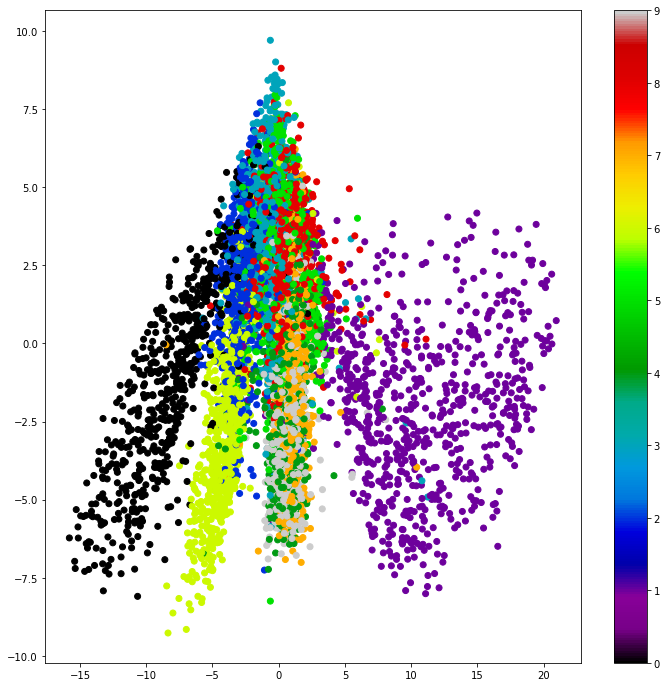

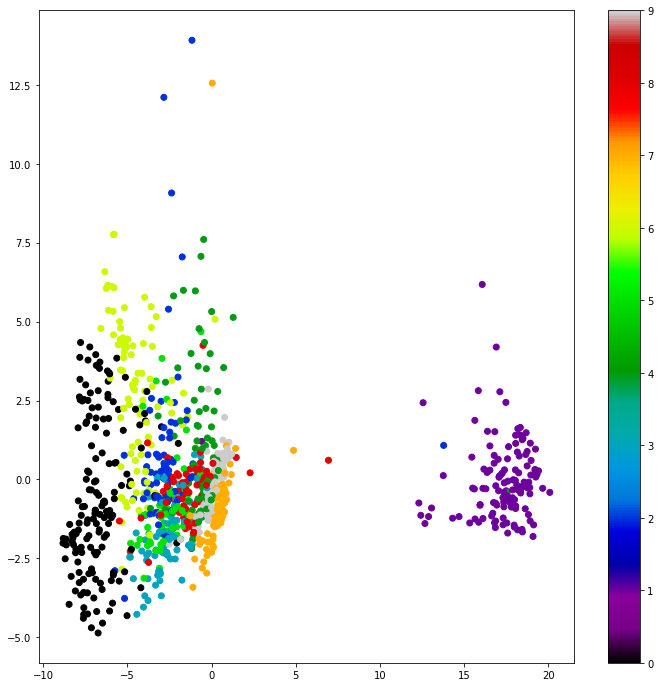

In [16]:
# 2D visualisation of features from images MNIST_test set in latent space 
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

latent_values_mnist=encoder.predict(mnist_x_new_test, batch_size=b_size)
latent_values_usps=encoder.predict(usps_x_new_test, batch_size=b_size)

vis_pca = PCA(n_components=2, random_state=0)
vis_data=vis_pca.fit_transform(latent_values_mnist)
plt.figure(figsize=(12, 12))
plt.scatter(vis_data[:, 0], vis_data[:, 1], c=mnist_y_new_test,cmap=plt.cm.nipy_spectral)
plt.colorbar()
plt.show()

# 2D visualisation of features from images USPS_test set in latent space 
vis_pca = PCA(n_components=2, random_state=0)
vis_data=vis_pca.fit_transform(latent_values_usps)
plt.figure(figsize=(12, 12))
plt.scatter(vis_data[:, 0], vis_data[:, 1], c=usps_y_new_test,cmap=plt.cm.nipy_spectral)
plt.colorbar()
plt.show()

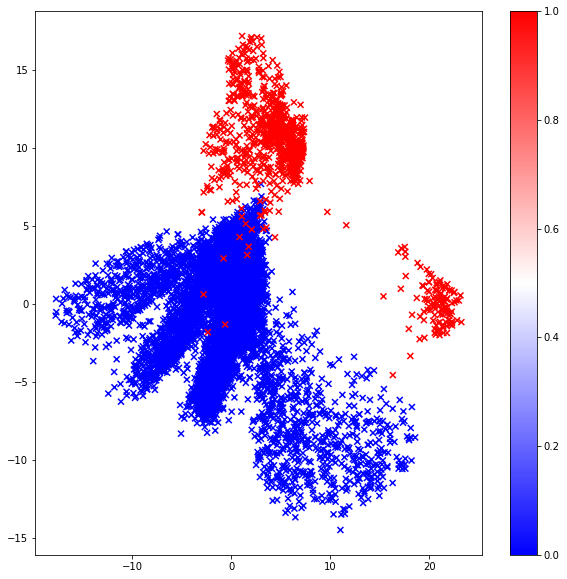

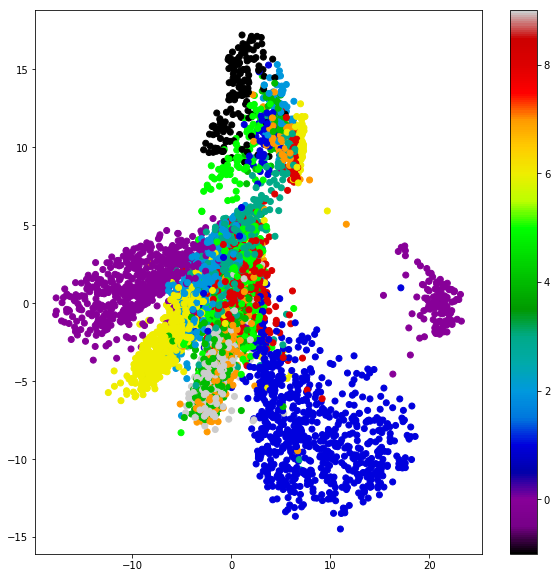

In [17]:
# 2D visualisation of features from images MNIST_test & USPS_test set in latent space 
# Red is USPS_test set & MNIST_test set
latent_values=np.concatenate((latent_values_mnist,latent_values_usps),axis=0)
labels_digits=np.concatenate((mnist_y_new_test,usps_y_new_test-1),axis=0)
labels_0=np.zeros(mnist_x_new_test.shape[0])
labels_1=np.ones(usps_x_new_test.shape[0])
labels=np.concatenate((labels_0,labels_1),axis=0)

vis_pca = PCA(n_components=2, random_state=0)
feature_vis=vis_pca.fit_transform(latent_values)

plt.figure(figsize=(10, 10))
plt.scatter(feature_vis[:, 0], feature_vis[:, 1], c=labels, marker='x', cmap=plt.cm.bwr, alpha=100)
plt.colorbar()
plt.show()

# 2D visualisation of features from images MNIST_test & USPS_test set in latent space 
plt.figure(figsize=(10, 10))
plt.scatter(feature_vis[:, 0], feature_vis[:, 1], c=labels_digits, marker='o', cmap=plt.cm.nipy_spectral, alpha=100)
plt.colorbar()
plt.show()

#### Saving model

In [18]:
# storing model to a json file and weights in HDF5 format
model_json = encoder.to_json()
# saving model
with open("cnn_exp3_vae_encoder.json", "w") as json_file:
    json_file.write(model_json)

# serialize weights to HDF5 and saving it
encoder.save_weights("cnn_exp3_vae_encoder.h5")
print("Saved model to disk")


Saved model to disk


In [19]:
# storing model to a json file and weights in HDF5 format
model_json = decoder.to_json()
# saving model
with open("cnn_exp3_vae_decoder.json", "w") as json_file:
    json_file.write(model_json)

# serialize weights to HDF5 and saving it
decoder.save_weights("cnn_exp3_vae_decoder.h5")
print("Saved model to disk")

Saved model to disk


In [20]:
# storing model to a json file and weights in HDF5 format
model_json = vae.to_json()
# saving model
with open("cnn_exp3_vae_vae.json", "w") as json_file:
    json_file.write(model_json)

# serialize weights to HDF5 and saving it
vae.save_weights("cnn_exp3_vae_vae.h5")
print("Saved model to disk")

Saved model to disk


#### Testing reconstruction ability of model

In [21]:
def reconstructor():
    examples_to_show = 10
    encode_decode_ = vae.predict(usps_x_new_test[0:b_size],batch_size=b_size)
    # Compare original images with their reconstructions
    f, a = plt.subplots(2, 10, figsize=(10, 2))
    for i in range(examples_to_show):
        a[0][i].imshow(np.reshape(usps_x_new_test[i], (16, 16)))
        a[1][i].imshow(np.reshape(encode_decode_[i], (16, 16)))
    f.show()
    plt.draw()
    plt.show()

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


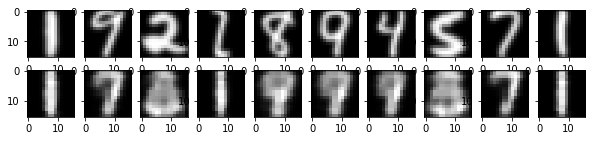

In [22]:
reconstructor()

#### Using CNN-VAE as a generative model

In [33]:
from scipy.stats import norm

def generation():
    # display a 2D manifold of the digits
    n = 15  # figure with 15x15 digits
    digit_size = 16
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
    # to produce values of the latent variables z, since the prior of the latent space is Gaussian
    grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
    grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder_generator.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    plt.imshow(figure, cmap='Greys_r')
    plt.show()

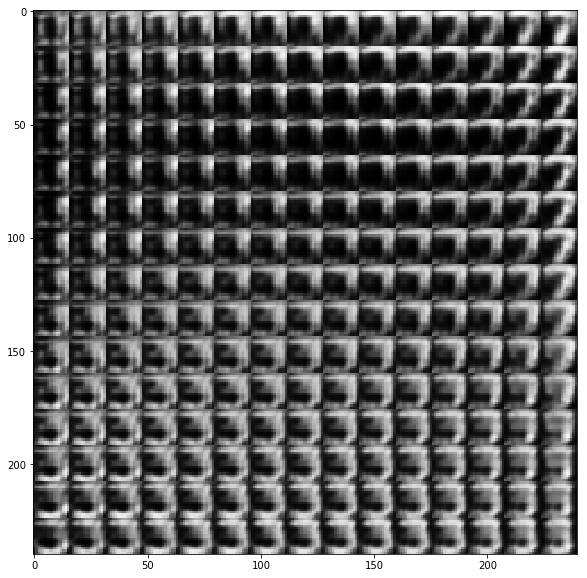

In [34]:
#Displaying images generated by the VAE autoencoder
generation()